## Project.9 Линейная алгебра. Защита персональных данных клиентов

    (yandex_practicum by student@pavel_matushevskiy, Volgograd 2022)

### Описание проекта
Вам нужно защитить данные клиентов страховой компании «Хоть потоп».   
Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию.   
Обоснуйте корректность его работы.  

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

### Описание данных
Набор данных находится в файле /datasets/insurance.csv.   

Признаки: пол, возраст и зарплата застрахованного, количество членов его семьи.  

Целевой признак: количество страховых выплат клиенту за последние 5 лет.

### 1. Подготовка библиотек и данных

In [4]:
# Базовая загрузка бибиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [5]:
# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [6]:
# расширение ноутбука на ширину всего экрана
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
# Подгрузим наш файл  с данными:
try:
    data = pd.read_csv('/datasets/insurance.csv')
except:
    data = pd.read_csv('datasets/insurance.csv')

In [8]:
# Посмотрим на данные в датасете:
data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


### Шаг 2. Предобработка данных

In [9]:
# Посмотрим на сводку по датасету: пропусков нет - это хорошо.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [10]:
# немного статистики по признакам  датасета:
data.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [11]:
# проверим, есть ли дубликаты в таблице с помощью метода duplicated. Они есть.
data.duplicated().sum()

153

In [12]:
data = data.drop_duplicates()

In [13]:
# посмотрим на кореляцию признаков между собой и особенно с таргетом - "Страховые выплаты":
# сильная корреляция "возраста клиента" с таргетом.
data.corr()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
Пол,1.000000,0.001953,0.015456,-0.007315,0.011565
Возраст,0.001953,1.000000,-0.017386,-0.009064,0.654964
Зарплата,0.015456,-0.017386,1.000000,-0.031687,-0.013123
Члены семьи,-0.007315,-0.009064,-0.031687,1.000000,-0.039303
Страховые выплаты,0.011565,0.654964,-0.013123,-0.039303,1.000000


In [14]:
# В рамках задачи считаем, что дополнительная обработка данных нам не нужна
# Разобьем наши данные на признаки и целевой показатель
features = data.drop('Страховые выплаты', axis=1)
target = data['Страховые выплаты']

features.shape

(4847, 4)

In [15]:
target.shape

(4847,)

### 3. Преобразование данных. Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$a = Xw$$

Задача обучения:

$$w = \arg\min_w MSE(Xw, y)$$

Формула обучения:

$$w = (X^T X)^{-1} X^T y$$

### 4. Ответим на поставленный вопрос:

Что произойдет, если признаки умножить на обратимую матрицу. Изменится ли качество линейной регрессии?

 Попробуем проверить гипотезу.

Для ответа необходимо доказать, что предсказания на исходных признаках будут равны предсказанию, вычесленному с учетом умножения признаков на заведомо обратимую матрицу.

1. Вычислим $w_2$. Подставим в выражение:

$$w_2 = ((XP)^T XP)^{-1} (XP)^T y$$

2. Раскроем скобки для транспонирования по свойству $(AB)^T = B^T A^T$

$$w_2 = (P^T X^T XP)^{-1} P^T X^T y$$

3. Вынесем P за скобки по свойству $(AB)^{-1} = B^{-1} A^{-1}$

$$w_2 = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y$$

4. Т.к. умножение матрицы на обратимую равно E, можем сократить часть $(P^T)^{-1} P^T$ до $E$ и сразу умножить на $X^T$

$$w_2 = P^{-1} (X^T X)^{-1} X^T y$$

5. Вспомним, что $w = (X^T X)^{-1} X^T y$ и произведем замену

$$w_2 = P^{-1} w$$

Теперь проверим признаки

1. Запишем формулу

$$a_2 = XPw_2$$

2. Подставим получившиеся значения

$$a_2 = XP P^{-1} w$$

3. Опять же, вспомним, что умножение на обратную матрицу даст $E$

$$a_2 = Xw$$

**4. Учитывая, что $a = Xw$, получаем:**

$$a_2 = a$$

### Вывод

Теперь мы точно можем сказать, что при умножении признаков на обратимую матрицу, качество линейной регрессии не изменится.

### 5. Алгоритм преобразования

1. создаём случайную матрицу
2. проверяем ее обратимость
3. создаём новую матрицу признаков
4. считаем метрики качества модели на исходных признаках, и сравниваем с метриками, полученными  на сгенерированных признаках

### 6. Проверка алгоритма

In [16]:
# Запрограммируем этот алгоритм, применив матричные операции

def generate_invertible_matrix(size):
    try:
        # что лучше выбрать: np.random.normal или np.random.randint?
        matrix = np.random.normal(size=(size, size))
        #matrix = np.random.randint(10,size=(size, size))
        # проверим матрицу на обратимость, если нет, пробуем сгенерировать еще раз
        # таким образом гарантируем, что матрица стопроцентно будет обратимой
        np.linalg.inv(matrix)
    except np.linalg.LinAlgError:
        matrix = generate_invertible_matrix(size)

    return matrix


def make_new_features(features):
    size = features.shape[1]
    P = generate_invertible_matrix(size)
    return features.dot(P)


new_features = make_new_features(features)

In [17]:
features

,Пол,Возраст,Зарплата,Члены семьи
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0
3,0,21.0,41700.0,2
4,1,28.0,26100.0,0
...,...,...,...,...
4995,0,28.0,35700.0,2
4996,0,34.0,52400.0,1
4997,0,20.0,33900.0,2
4998,1,22.0,32700.0,3


In [16]:
new_features

,0,1,2,3
0,-19937.419741,23764.946276,-27291.197585,67914.631559
1,-15282.921236,18214.293112,-20880.057443,52041.858676
2,-8447.499634,10068.534346,-11532.331348,28761.888344
3,-16754.278649,19968.763209,-22970.594102,57089.813759
4,-10494.972370,12510.725408,-14348.342809,35741.040791
...,...,...,...,...
4995,-14349.750100,17101.450011,-19645.488844,48882.578675
4996,-21056.629355,25098.799985,-28850.841317,71742.503525
4997,-13622.416543,16235.037821,-18667.881084,46413.505120
4998,-13143.361638,15662.899534,-18000.367072,44773.050825


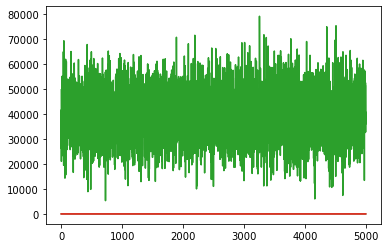

In [18]:
plot.plot(features)
plot.show()

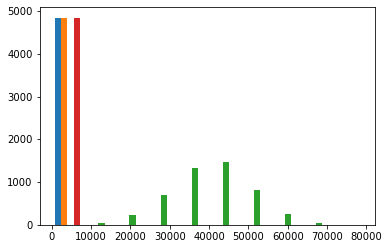

In [19]:
plot.hist(features)
plot.show()

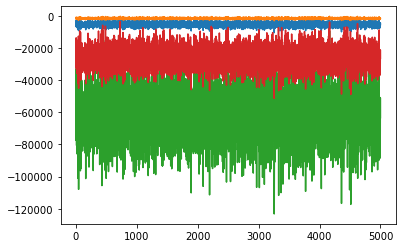

In [20]:
plot.plot(new_features)
plot.show()

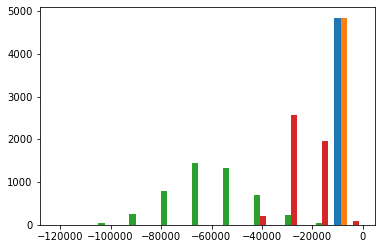

In [21]:
plot.hist(new_features)
plot.show()

In [22]:
# Теперь обучим 2 модели линейной регрессии  и сравним результаты:
model_base = LinearRegression()
model_base.fit(features, target)
predict = model_base.predict(features)

model_new = LinearRegression()
model_new.fit(new_features, target)
new_predict = model_new.predict(new_features)

# Сравним R2 метрики:
print('R2 features = ', r2_score(target, predict))
print('R2 new_features = ', r2_score(target, new_predict))

R2 features =  0.4302010044852066
R2 new_features =  0.4302010044852165


* Можно х2 улучшить результаты модели несложными манипуляциями с признаками для обучения (feature engineering сделать):

In [23]:
# вариант 1:
model_new = LinearRegression()
new_features2 = features*(features**4)
model_new.fit(new_features2, target)
new_predict = model_new.predict(new_features2)

# Сравним R2 метрики:
print('R2 features = ', r2_score(target, predict))
print('R2 new_features = ', r2_score(target, new_predict))

R2 features =  0.4302010044852066
R2 new_features =  0.8307185892645722


In [23]:
# вариант 2
poly_reg = PolynomialFeatures(degree=4)
new_features3 = poly_reg.fit_transform(features)
model_new.fit(new_features3, target)
new_predict = model_new.predict(new_features3)

# Сравним R2 метрики:
print('R2 features = ', r2_score(target, predict))
print('R2 new_features = ', r2_score(target, new_predict))

R2 features =  0.4302010044852066
R2 new_features =  0.8874020497615601


# Общий вывод

    1. Мы изучили данные
    2. Доказали, что при умножении признаков на обратимую матрицу качество линейной регрессии не изменится и обосновали это заключение
    3. Помимо этого, мы также запрограммировали этот алгоритм и проверили качество линейной регрессии после преобразования, убедившись, что оно не изменилось.
    
    Таким образом, у нас получилось создать метод преобразования данных, по которому будет сложно восстановить персональную информацию, но который не будет влиять на качество линейной регрессии. Что и требовалось получить.)


